# Transfer Learning with Masterful

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_transfer_learning.ipynb
[2]:http://docs.masterfulai.com/0.4.1/notebooks/guide_transfer_learning.ipynb

This guide will show how to take advantage of loading pretrained weights into a base model to speed up training with Masterful and achieve higher metric scores. It is inspired by concepts discussed in the [Keras Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/) guide which is also similar to the one on the [TensorFlow](https://www.tensorflow.org/tutorials/images/transfer_learning) website.

## Load the Data

Import TensorFlow Datasets and proceed to load Eurosat. To reduce runtime the `dataset_ratio` can be set below `1.0` to select only a subset of the entire dataset. The `holdout_ratio` variable will determine how many samples of the Eurosat dataset will be used for validation within the train loop and for a final evaluation once the optimal model has been produced. This code will split the holdout dataset in half and allocate each for the validation and test sets.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import masterful
masterful = masterful.register()

num_classes = 10
dataset_ratio = 1.0
holdout_ratio = 0.3
eurosat_dataset, dataset_info = tfds.load(
    "eurosat", split=f"train[:{int(dataset_ratio * 100)}%]", as_supervised=True, with_info=True)
class_names = dataset_info.features['label'].names
training_dataset, holdout_dataset = masterful.utils.dataset.split_dataset(
    labeled_data=eurosat_dataset, validation_ratio=holdout_ratio)
validation_dataset = holdout_dataset.shard(num_shards=2, index=0)
test_dataset = holdout_dataset.shard(num_shards=2, index=1)

print(
    f"Training Samples: {masterful.utils.dataset.cardinality(training_dataset)}, "
    f"Validation Samples: {masterful.utils.dataset.cardinality(validation_dataset)}, "
    f"Test Samples: {masterful.utils.dataset.cardinality(test_dataset)}")

MASTERFUL: Your account has been successfully registered. Masterful v0.4.1 is loaded.
Training Samples: 18900, Validation Samples: 4050, Test Samples: 4050


### Visualize the Data

A visual spot check ensures that the Eurosat dataset has been loaded correctly and gives us an idea of what kind of images are associated with the 10 categories that will be used to train an image classifier.

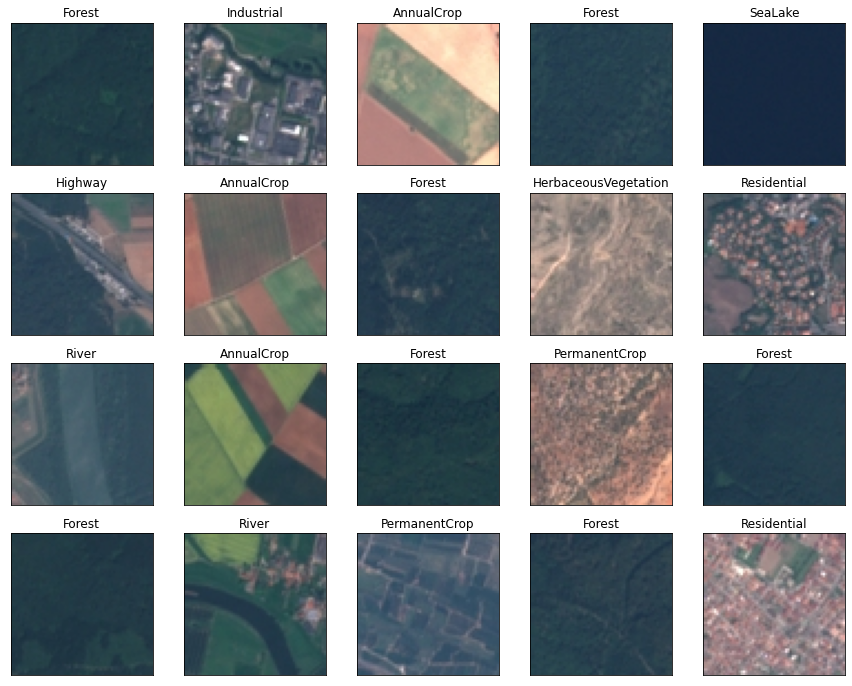

In [2]:
import matplotlib.pyplot as plt
import numpy as np

row_count = 4
col_count = 5
curr_row = 0
fig, axes = plt.subplots(4, 5, figsize=(col_count * 3, row_count * 3))

for i, (x, y) in enumerate(test_dataset.take(row_count * col_count)):
    axes[curr_row, i % col_count].imshow(x)
    axes[curr_row, i % col_count].set_title(class_names[y])
    axes[curr_row, i % col_count].set_xticks([])
    axes[curr_row, i % col_count].set_yticks([])

    if i % col_count == col_count - 1:
        curr_row += 1

plt.show()

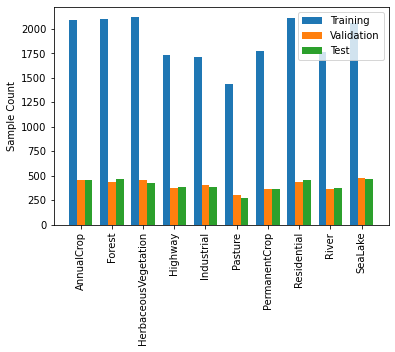

In [3]:
training_counts = np.unique(
    np.fromiter(training_dataset.map(lambda x, y: y), int), return_counts=True)[1]
validation_counts = np.unique(
    np.fromiter(validation_dataset.map(lambda x, y: y), int), return_counts=True)[1]
test_counts = np.unique(
    np.fromiter(test_dataset.map(lambda x, y: y), int), return_counts=True)[1]

x = np.arange(len(class_names))
bar_width = 0.25

fig, axes = plt.subplots()
training_bars = axes.bar(x - bar_width, training_counts, bar_width, label="Training")
validation_bars = axes.bar(x, validation_counts, bar_width, label="Validation")
test_bars = axes.bar(x + bar_width, test_counts, bar_width, label="Test")

axes.set_ylabel("Sample Count")
axes.set_xticks(x)
axes.set_xticklabels(class_names, rotation=90)
axes.legend()

plt.show()

## Preprocess the Data

The training dataset passed to `masterful.spec.create_model_and_data_specs()` expects a one hot integer encoding of the label.

Only the training dataset ought to reshuffle after each epoch of training. If training the model exhausts all RAM that is available to the system, lower the `buffer_size` value for each dataset in the code cell below to circumvent this issue.

In [4]:
training_dataset = training_dataset.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, dtype=tf.int32), depth=num_classes, axis=-1)))
validation_dataset = validation_dataset.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, dtype=tf.int32), depth=num_classes, axis=-1)))
test_dataset = test_dataset.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, dtype=tf.int32), depth=num_classes, axis=-1)))

training_dataset = training_dataset.shuffle(
    buffer_size=masterful.utils.dataset.cardinality(training_dataset),
    reshuffle_each_iteration=True)
validation_dataset = validation_dataset.shuffle(
    buffer_size=masterful.utils.dataset.cardinality(validation_dataset),
    reshuffle_each_iteration=False)
test_dataset = test_dataset.shuffle(
    buffer_size=masterful.utils.dataset.cardinality(test_dataset),
    reshuffle_each_iteration=False)

## Create the Model

The easiest method of loading pre-trained weights into the base model is by assigning `weights="imagenet"` during its instantiation. Doing so will allow the new model to leverage learned features from the much larger ImageNet dataset to perform better classification on the Eurosat dataset.

Unlike the Keras and TensorFlow transfer learning guides, this model will not freeze it's trainable parameters. The `masterful.autofit()` function will instead use a warm-up learning rate scheduler initialized with a low value to gradually update the pre-trained weights and thereby avoid large gradient updates which would destroy the pre-trained features. However, when the base model is called it's training parameter is set to false. This is purposely done to rune the batch normalization layers within it in inference mode.

To reiterate what is written in the Keras transfer learning and fine-tuning guide:
* BatchNormalization contains two non-trainable weights that get updated during training. These are the variables tracking the mean and variance of the inputs.
* When you set `bn_layer.trainable = False`, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics. This is not the case for other layers in general, as weight trainability and inference/training modes are two orthogonal concepts. But the two are tied in the case of the BatchNormalization layer.
* When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training=False` when calling the base model. Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.

In [5]:
input_shape = (64, 64, 3)
base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                        weights="imagenet",
                                                        input_shape=input_shape)
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-05-10 19:08:28.063 ip-172-31-35-123:22826 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-05-10 19:08:28.097 ip-172-31-35-123:22826 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 64, 64, 3)         0         
____________

## Train with Masterful

With the model already loaded with pre-trained weights, no additional step is required when creating the dataset, optimization, SSL, and regularization parameters for training. `masterful.training.train` will automatically apply the learning rate warm-up scheduler to get the most out of transfer learning.

In [6]:
model_params = masterful.architecture.learn_architecture_params(
    model=model,
    task=masterful.enums.Task.CLASSIFICATION,
    input_range=masterful.enums.ImageRange.ZERO_255,
    num_classes=num_classes,
    prediction_logits=True,
)

In [7]:
training_dataset_params = masterful.data.learn_data_params(
    dataset=training_dataset,
    task=masterful.enums.Task.CLASSIFICATION,
    image_range=masterful.enums.ImageRange.ZERO_255,
    num_classes=num_classes,
    sparse_labels=False,
)

In [8]:
validation_dataset_params = masterful.data.learn_data_params(
    dataset=validation_dataset,
    task=masterful.enums.Task.CLASSIFICATION,
    image_range=masterful.enums.ImageRange.ZERO_255,
    num_classes=num_classes,
    sparse_labels=False,
)

In [9]:
optimization_params = masterful.optimization.learn_optimization_params(
    model=model,
    model_params=model_params,
    dataset=training_dataset,
    dataset_params=training_dataset_params,
)

MASTERFUL: Learning optimal batch size.
MASTERFUL: Learning optimal initial learning rate for batch size 256.


In [10]:
ssl_params = masterful.ssl.learn_ssl_params(
    training_dataset=training_dataset,
    training_dataset_params=training_dataset_params,
)

In [11]:
regularization_params = masterful.regularization.learn_regularization_params(
  model=model,
  model_params=model_params,
  optimization_params=optimization_params,
  training_dataset=training_dataset,
  training_dataset_params=training_dataset_params,
  validation_dataset=validation_dataset,
  validation_dataset_params=validation_dataset_params,
)

MASTERFUL: Meta-Learning Regularization Parameters...
MASTERFUL: Warming up model for analysis.
MASTERFUL: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL: 	Warming up training for 500 steps.
100%|██████████| 500/500 [07:20<00:00,  1.14steps/s] 
MASTERFUL: 	Validating batch norm statistics after warmup for stability (this could take a few minutes).
MASTERFUL: Analyzing baseline model performance. Training until validation loss stabilizes...
Baseline Training: 100%|██████████| 2250/2250 [24:01<00:00,  1.56steps/s]  
MASTERFUL: Baseline training complete.
MASTERFUL: Meta-Learning Basic Data Augmentations...
Node 4/4: 100%|██████████| 1800/1800 [19:03<00:00,  1.57steps/s]
MASTERFUL: Meta-Learning Data Augmentation Clusters...
Node 10/10: 100%|██████████| 1800/1800 [19:35<00:00,  1.53steps/s]
MASTERFUL: Meta-Learning Label Based Regularization...
Node 2/2: 100%|██████████| 1800/1800 [19:47<00:00,  1.52steps/s]
MASTERFUL: Meta-Learning Weight Based Regularizatio

In [12]:
training_report = masterful.training.train(
    model=model,
    model_params=model_params,
    optimization_params=optimization_params,
    regularization_params=regularization_params,
    ssl_params=ssl_params,
    training_dataset=training_dataset,
    training_dataset_params=training_dataset_params,
    validation_dataset=validation_dataset,
    validation_dataset_params=validation_dataset_params,
)

MASTERFUL: Training model with semi-supervised learning disabled.
MASTERFUL: Performing basic dataset analysis.
MASTERFUL: Training model with:
MASTERFUL: 	18900 labeled examples.
MASTERFUL: 	4050 validation examples.
MASTERFUL: 	0 synthetic examples.
MASTERFUL: 	0 unlabeled examples.
MASTERFUL: Training model with learned parameters closet-stupendous-machine in two phases.
MASTERFUL: The first phase is supervised training with the learned parameters.
MASTERFUL: The second phase is semi-supervised training to boost performance.
MASTERFUL: Warming up model for supervised training.
MASTERFUL: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL: 	Warming up training for 500 steps.
100%|██████████| 500/500 [07:47<00:00,  1.07steps/s]
MASTERFUL: 	Validating batch norm statistics after warmup for stability (this could take a few minutes).
MASTERFUL: Starting Phase 1: Supervised training until the validation loss stabilizes...
Supervised Training: 100%|██████████| 576

## Evaluate on the Test Set

When training with Masterful for 87 minutes using 70% of the Eurosat dataset on an EC2 instance equipped with a K80 GPU, a categorical accuracy of 97.28% is obtained. However, if this experiment were to be re-run without ImageNet pretrained weights, the model would have only achieved an accuracy of 94.66% in 128 minutes. When the training set is larger and more representative of the task that is to be performed on the test set, the difference in accuracy is minimized, but even reducing the time to train makes transfer learning a desirable technique that can be used despite domain shift between ImageNet and the target dataset.

In [13]:
model.evaluate(test_dataset.batch(128), return_dict=True)

32/32 [==============================] - 6s 113ms/step - loss: 0.0917 - categorical_accuracy: 0.9728


{'loss': 0.09170320630073547, 'categorical_accuracy': 0.9728395342826843}